# Modelling of semi-arid rangelands for sustainable management with the Python API of the ILWIS GIS/RS software

<b>Claudio Piccinini 2016; c.piccinini@utwente.nl</b>
<br/><br/>
<b>This workshop is based on A.G Toxopeus, 1999, "An interactive spatial and temporal modelling system as a tool in ecosystem management", ITC-Enschede</b>

<i>I wish to thank various people for their contribution to this workshop: <br/>
Bas Retsios for developing the Ilwis software and fixing various ilwisobjects bugs<br/>
Martin Schouwenburg for developing the Ilwis software<br/>
Jamshid Farifteh for sharing some datasets<br/>
Joao Bonina for developing ilwisobjects<br/>
Bert A.G. Toxopeus for sharing the original model and the datasets<br/>
Rob Lemmens for promoting this workshop</i>

## RANGELANDS MANAGEMENT MODEL IN THE MARA RIVER BASIN

Variability of the climatic and the drought phenomena makes range productivity a function of climate. <br/>
In the study area the climate is variable and drought is a major characteristic.
Therefore the pastoralis (Maasai) make great use of movement to take stock to favourable areas for grazing as forage declines in one area (in reality herd movements are restricted to the boundaries of the group ranches).<br/>
To construct a model calculating and displaying the spatial and temporal variation of the expected impact of the grazing activities of both wildlife and livestock during the long dry season different data has to be collected: 

- animal distribution and density per wet and or dry season
- The Maasai herding strategies
- wildlife migratory routes
- the forage production of various land cover types
- the water availability during the dry season
- rainfall
- etc.

The model consists of 3 parts:
- the forage availability ( production)
- the forage demand
- accessibility for both wildlife and livestock

<img src="files/images/model.jpg" width=800>

- The forage availability is related to the productivity of the rangelands under certain climatological and biophysical conditions. <br/>
For this model biophysical conditions (slope map and soil map) are not changing very fast or varying much in time, but the climate aspect (rainfall), has the most ignificant contribution to the productivity of the rangelands.<br/>Rainfall variability is high and varies each rainy season; therefore the production aspect is the yearly (seasonal) variable in time. 

- The forage demand is related to the distribution and density of both wildlife and livestock during different periods ( e.g. wet and/or dry season). These densities and distributions are determined by the actual census data and relatively constant if considered on a long term basis.

- The accessibility is a matter of the availability of drinking water for especially the water dependent wildlife species and livestock during the dry season. But also other aspects such as topography, land cover, and surface roughness play a role. <br/>
Again, changes in this aspect are of more long term character and if changes  occur, they are relatively easy to update in the model

## 1. FORAGE AVAILABILITY (PRODUCTION)

Is a function of rainfall, soil condition, land cover, and topography.

### 1.1 Perennial grass cover

The vegetation cover has been compiled with the interpretation of satellite images, aerial photographs, data collection during field surveys. Each vegetation type has an average % perennial grass cover

In [41]:
#this code will add a field "reclass" to the raster table "vegetation.tbt"


import ilwis
ilwis.disconnectIssueLogger() #hide logs


#set your ilwisobjects current working catalog!
pth = r"C:\Users\piccinini\PycharmProjects\geopython2016\data"


ilwis.Engine.setWorkingCatalog(pth)

#open a ilwis table
table = ilwis.Table("vegetation.tbt")
print(table.columns())

#add new column if necessary
if "reclass" not in table.columns():
    table.addColumn("reclass", "value")
    

print(table.columns())

('DN', 'reclass')
('DN', 'reclass')


In [42]:
#this is a utility function that visualize a raster coverage


import numpy as np
import matplotlib.pyplot as plt

#we want inline charts
%matplotlib inline 

def visualize(rc, colorbar=True, minvalue = 0, cmap= 'jet'):
    """visualize a map from a pixel iterator
    rc: raster coverage
    colorbar: add a colorbar to the chart?
    minvalue: minimum value to be visualized
    cmap: the colormap for the chart ; look at http://matplotlib.org/users/colormaps.html
    """
    
    #create "pixel iterator" and get the x,y size through the box object
    rciter = iter(rc)
    bx = rciter.box()
    columns = bx.size().xsize
    rows = bx.size().ysize

    #####visualize DN map#####

    # convert the pixel iterator to a numpy array
    nparr = np.fromiter(rciter,np.float, rc.size().linearSize()) 
    nparr = nparr.reshape(rows,columns )
    #hide nodata value
    mask = nparr<minvalue 
    nparr[mask]=minvalue

    #visualize with matplotlib
    plt.imshow(nparr, cmap=plt.get_cmap(cmap))
    if colorbar: plt.colorbar()
    plt.show()

In [43]:
# list all the available ilwis operations
print(ilwis.Engine().operations())

('setsttributetable', 'groupby', 'numbercondition', 'junction', 'createrastercoverage', 'saveas', 'joinattributes', 'testoperation', 'createprojectedcoordinatesystem', 'createcornersgeoreference', 'createpalettedomain', 'createintervaldomain', 'createidentifierdomain', 'createthematicdomain', 'createnumericdomain', 'columnunaryoperation', 'aggregation', 'convertcolumndomain', 'setworkingcatalog', 'contains', 'covers', 'coveredby', 'touches', 'intersects', 'disjoint', 'within', 'equals', 'crosses', 'overlaps', 'setvaluerange', 'binarymathtable', 'selection', 'mastergeoreference', 'binarymathfeatures', 'binarymathraster', 'selection', 'iffeature', 'stringfind', 'stringsub', 'stringreplace', 'rastersize', 'text2output', 'coord2pixel', 'coordinate', 'pixel', 'pixel2coord', 'selection', 'assignment', 'sin', 'cos', 'tan', 'asin', 'acos', 'atan', 'log10', 'ln', 'abs', 'sqrt', 'ceil', 'floor', 'sgn', 'cosh', 'sinh', 'sin', 'cos', 'tan', 'asin', 'acos', 'atan', 'log10', 'ln', 'abs', 'sqrt', 'ce

In [44]:
#what are the parameters for the selection operation?
print(ilwis.Engine().operationMetaData("selection"))

selection(table,selection-definition); selection(featurecoverage,selection-definition); selection(coverage,selection-definition)


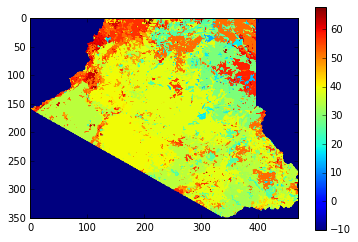

In [45]:
#open raster and filter the DN column usin the selection operation
#this is necessary because vegetation il linked to a vegetation table

rc = ilwis.RasterCoverage("vegetation.mpr")
rcdn = ilwis.Engine.do("selection",rc,'"attributes(DN)"')
   
visualize(rcdn, minvalue = -10,   cmap= 'jet')

In [46]:
# we want to reclassify the pixel values according to values stored in the table grasscover.csv
# the new value is a grass percentage coverage

import csv
import os

#set your Python current working directory!
os.chdir(pth)

reclass ={}

f = open("grasscover.csv")
f.readline() #skip field names
r = csv.reader(f)

for line in r:
    #print(line)
    if int(line[1]) != 0 : 
        reclass[int(line[0])]=int(line[1])
    
print(reclass)  

{48: 90, 64: 20, 18: 60, 35: 70, 52: 55, 22: 35, 39: 15, 25: 65, 62: 40, 15: 50}


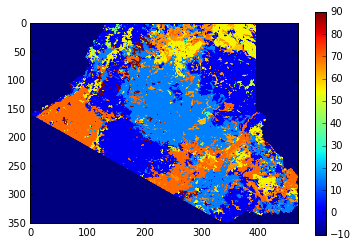

In [47]:
# we use the dictionary to add values to the 'reclass' column

idx0 = table.columnIndex('DN')
idx = table.columnIndex('reclass')

rec = table.recordCount()

for i in range(rec):
    if table.record(i)[idx0] in reclass:
        table.setCell("reclass", i, reclass[table.record(i)[idx0]])
    else:
        table.setCell("reclass", i, 0)

#for i in range(rec):
#    print(table.record(i))


#saving the updated ilwis table
table.store("vegetation.tbt","table", "ilwis3")


#use the select operator to extract the perennial grasscover percentage map
perennial_grasscover = ilwis.Engine.do("selection",rc,'"attributes(reclass)"')
visualize(perennial_grasscover, minvalue = -10)

In [48]:
#saving raster coverages is done with .store
# raster coverages can be saved to different formats (e.g. Geotiff)

#perennial_grasscover.store("perennial_grasscover","GTiff","gdal")
perennial_grasscover.store("perennial_grasscover","map","ilwis3")

### 1.2 Rainfall map (wet season)

A long term rainfall distribution map (RF_distribution in mm/month) for the wet season can be calculated by interpolation of rainfall data

In [49]:
# we want to look inside the rain folder and create a list of .mpr files 
# these files contain rain data for the most rainy months (march,april,may)

ndipath = r"rain"
inimgfrmt = [".mpr"]
rain_rasters = []

#this will list all the folder content
imgs = os.listdir(ndipath)

#we iterate the content and extract the .mpr file names
for i in imgs:
    if os.path.isfile(ndipath + '/' + i) and (os.path.splitext(ndipath + '/' + i)[-1] in inimgfrmt):
        rain_rasters.append(i)
        
print(rain_rasters)

['RBC_200603.mpr', 'RBC_200604.mpr', 'RBC_200605.mpr', 'RBC_200703.mpr', 'RBC_200704.mpr', 'RBC_200705.mpr', 'RBC_200803.mpr', 'RBC_200804.mpr', 'RBC_200805.mpr', 'RBC_200903.mpr', 'RBC_200904.mpr', 'RBC_200905.mpr', 'RBC_201003.mpr', 'RBC_201004.mpr', 'RBC_201005.mpr', 'RBC_201103.mpr', 'RBC_201104.mpr', 'RBC_201105.mpr', 'RBC_201203.mpr', 'RBC_201204.mpr', 'RBC_201205.mpr', 'RBC_201303.mpr', 'RBC_201304.mpr', 'RBC_201305.mpr', 'RBC_201403.mpr', 'RBC_201404.mpr', 'RBC_201405.mpr', 'RBC_201503.mpr', 'RBC_201504.mpr', 'RBC_201505.mpr']


In [50]:
# we calculate the long term average for the wet season


RF_distribution = ilwis.RasterCoverage(ilwis.Engine.getLocation()+"/rain/"+rain_rasters[0])

for i in range(1, len(rain_rasters)):
    print(rain_rasters[i], end=" - ")
    monthly_rain = ilwis.RasterCoverage(ilwis.Engine.getLocation()+"/rain/"+rain_rasters[i])
    RF_distribution = (RF_distribution + monthly_rain)
    
RF_distribution = RF_distribution/len(rain_rasters)


RBC_200604.mpr - RBC_200605.mpr - RBC_200703.mpr - RBC_200704.mpr - RBC_200705.mpr - RBC_200803.mpr - RBC_200804.mpr - RBC_200805.mpr - RBC_200903.mpr - RBC_200904.mpr - RBC_200905.mpr - RBC_201003.mpr - RBC_201004.mpr - RBC_201005.mpr - RBC_201103.mpr - RBC_201104.mpr - RBC_201105.mpr - RBC_201203.mpr - RBC_201204.mpr - RBC_201205.mpr - RBC_201303.mpr - RBC_201304.mpr - RBC_201305.mpr - RBC_201403.mpr - RBC_201404.mpr - RBC_201405.mpr - RBC_201503.mpr - RBC_201504.mpr - RBC_201505.mpr - 

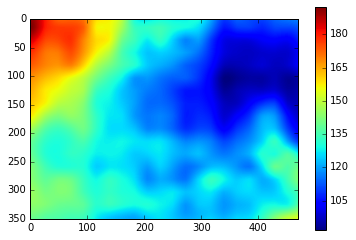

In [51]:
visualize(RF_distribution)

In [52]:
#RF_distribution.store("RF_distribution","GTiff","gdal")
RF_distribution.store("RF_distribution","map","ilwis3")

### 1.3 Conversion of rainfall to water availability for ground layer vegetation

The availability of water can be directly related to the rainfall for different groups of soils, because run-off and run-on and the water holding capacity for these groups of soils are about the same.<br/> 
The area has been divided into 4 different physical groups, taking topography into account as well: 
- where some run-off occur occasionally (4) 
- where run-off is rather common (3)
- where some run-off occurs regularly (2)
- swamp areas (1)

The rainfall_effectivity map (RF_effectivity) is created assigning one of the above factors to the soil map

In [53]:
table = ilwis.Table(ilwis.Engine.getLocation()+"/soil/soils.tbt")

print(table.columns())

print(table.record(0))

('Id', 'Rain_Effec', 'PH', 'slope__', 'gravel__', 'sand__', 'silt__', 'clay__', 'soils', 'coverage_key')
(0.0, 1.0, 7.2, 4.0, 0.0, 46.0, 22.0, 32.0, 0.0, 0)


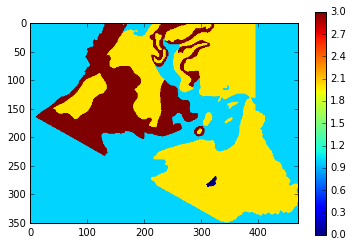

In [54]:
# the soil raster coverage has already a Rain_Effec field
soils = ilwis.RasterCoverage(ilwis.Engine.getLocation()+"/soil/soils.mpr")
RF_effectivity = ilwis.Engine.do("selection",soils,'"attributes(Rain_Effec)"')

visualize(RF_effectivity)

In [55]:
#RF_effectivity.store("RF_effectivity","GTiff","gdal")
RF_effectivity.store("RF_effectivity","map","ilwis3")

### 1.4 Peak standing crop of perennial grasses

Several methods are used to estimate the production of forage for large herbivores. The forage production is always directly or indirectly a product of the amount of rainfall and grass cover, but the final peak standing crop at the end of the rainy season depends on a number of other factors as well, like nutrient availability, the contribution of perennial and/or annual grasses and forbs, the amount of raifall during the growing season and the length of the growing season, and the (non) utilization of swamp vegetation.<br/>
The nutrient supply in the relatively poor west African savanna soils is often a limiting factor in plant growth as especially nitrogen and phosphorus limit the primary production at a rainfall more than 400 mm per growing period. <br/>
In the study area rainfall generally never exceeds 400 mm per growing season, the nutrient availability is not assumed to be limiting for the growth of perennial grasses during the growing season.<br/>
Swap vegetation and annual grasses are not used for the estimation of the peak standing crop, because of their limited contribution to the total forage to be used by the large herbivores during the dry season.<br/><br/>
The sum of the rainfall during the growing season will determine the peak standing crop according to the equation: <br/>

<b>peak_standing_crop = RF_effectivity X perennial_grasscover X  RF_distribution</b>

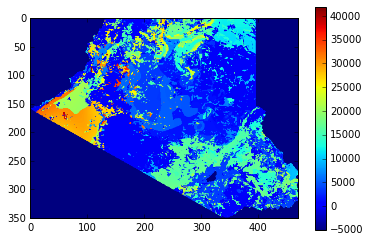

In [56]:
# raster coverages support common operations such as sum, subtraction, multiplication
peak_standing_crop = RF_effectivity *  perennial_grasscover * RF_distribution

visualize(peak_standing_crop, minvalue = -5000)

In [57]:
#peak_standing_crop.store("peak_standing_crop","GTiff","gdal")
peak_standing_crop.store("peak_standing_crop","map","ilwis3")

### 1.5 Availability of forage for the large herbivores

According to the FAO a combined factor called "edible forage", should be reduced from the herbaceous peak standing crop to account for grazing efficiency, forage loss and a "proper use factor" to account for sustainability. <br/>
This factor may vary according to different researches and situation; studies conducted in eastern Kenya suggest that no more than 55% of the grass cover should be removed in one way or the other to keep the grassland at least in the same condition as it was before. <br/><br/>
So at least 45% of the peak standing crop should be left at the beginning of the next rainy season; additional 10% will be reduced because of invertebrate consumption and natural decay.

<b>sustainable_available = peak_standing_crop X 0.45</b>

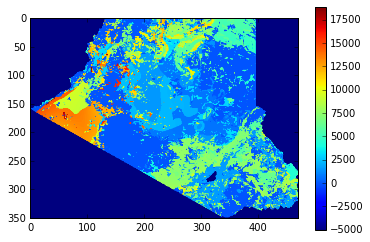

In [58]:
sustainable_available = peak_standing_crop * 0.45

visualize(sustainable_available, minvalue = -5000)

In [59]:
#sustainable_available.store("sustainable_available","GTiff","gdal")
sustainable_available.store("sustainable_available","map","ilwis3")

## 2. FORAGE DEMAND OF WILDLIFE AND LIVESTOCK

### 2.1 Relevant large herbivores

The estimation and the density of the herbivores is based on surveys and animal counts. <br/>
The study area was divided into a 5X5 km grid.

In [60]:
#let's have a look at the Boundaries_Mamase_Grid table structure
table = ilwis.Table("Boundaries_Mamase_Grid.tbt")
print(table.columns())

print(table.record(0))

('FID_Bounda', 'Id', 'FID_narok_', 'AREA', 'PERIMETER', 'NARO5K_', 'NARO5K_ID', 'UNIT', 'LAT', 'LONG', 'NUM', 'boundaries_mamase_grid', 'coverage_key')
(0.0, 0.0, 225.0, 25041700.0, 20016.7, 227.0, 226.0, -4655.0, 8875.0, 7825.0, 0.0, 0.0, 0)


In [61]:
# this function will create a random matplotlib colormap
# based on https://gist.github.com/jakevdp/91077b0cae40f8f8244a

import matplotlib.pyplot as plt
import numpy as np

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    """
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.random.random(N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

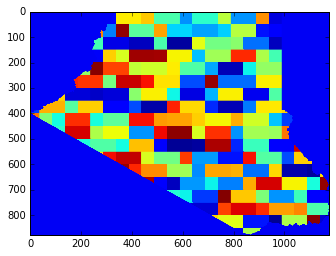

In [62]:
# the field FID_narok_ contains the unnique cell id
grid_raster = ilwis.RasterCoverage("Boundaries_Mamase_Grid.mpr")
grid_id = ilwis.Engine.do("selection",grid_raster,'"attributes(FID_narok_)"')

visualize(grid_id,colorbar=False, cmap=discrete_cmap(500, 'jet'))

The model calculate the forage needs for grazers and mixed feeders, browsers are excluded.

For grazers the total forage will be used <br/> 
<img src="files/images/grazers.jpg" width=600>

For mixed-feeders only the proportion of their forage need that is covered by grass will be used<br/>
- if they have a preference for grass, 65% of their diet will be considered
- if they have a preference for browse, only 35% of their diet will be considered<br/>
<img src="files/images/mixfeeders.jpg" width=600>

### 2.2 Body weight vs. energy intake

The estimated average body weight of adult animals is a compilation of estimates given by many authors.<br/>
Forage requirements are well studied for domestic herbivores, less for wildlife.
Different methodologies are applied to estimate the forage need ( daily dry matter requirement) for herbivores.<br/>
We can use an avarage of values from different studies of life body weight and their dry matter (DM) requirements per species under semiarid rangelands conditions during the long dry season.<br/><br/>
The table below shows an example of the daily dry matter intake of grass of free ranging hervivores during the dry season and the percentages of the daily dry matter intake in relation to their life body weight.<br/><br/>
<img src="files/images/dmtable.jpg" width=600>

### 2.3 Census data

In [63]:
f = open("grids/wildlife.csv")
print(f.readline())
print(f.readline())
f.close()

f = open("grids/livestock.csv")
print(f.readline())
print(f.readline())
f.close()

cell,W1,W2,W3,W4,W5,W6

636,1,0,0,2,4,5

cell,L1,L2,L3,L4,L5,L6

636,0,3,1,2,0,3



In [64]:
# we join the grid with the census data
#this works with feature coverage maps, therefore we can convert to raster coverage

wildlife = ilwis.Table(ilwis.Engine.getLocation() + "/grids/wildlife.csv")
grid = ilwis.FeatureCoverage("Boundaries_Mamase_Grid.mpa")
census_wildlife = ilwis.Engine.do("joinattributes", grid, "FID_narok_", wildlife,"cell")
census_wildlife_raster = ilwis.Engine.do("polygon2raster",census_wildlife,ilwis.GeoReference("mamase.grf"))
census_wildlife_raster.store("census_wildlife","map","ilwis3")

livestock = ilwis.Table(ilwis.Engine.getLocation() + "/grids/livestock.csv")
census_livestock = ilwis.Engine.do("joinattributes", grid, "FID_narok_", livestock,"cell")
census_livestock_raster = ilwis.Engine.do("polygon2raster",census_livestock,ilwis.GeoReference("mamase.grf"))
census_livestock_raster.store("census_livestock","map","ilwis3")

### 2.4 Wildlife forage demand for the long dry season

The presence of wildlife is considered a fact of life and in principle not to be managed. Therefore, the forage consumption by wildlife is abstracted from the plant forage available.<br/> 
What is left can be utilized by livestock.<br/> 
By determining the length of the dry season the expected forage consumption can be calculated.<br/> 

The lenght of the long dry season is combined with the average number of days per month(30.4), the dry matter intake value of a species and linked to the map with the distribution and density of each wildlife species. <br/><br/>

<b>wildlife_demand = number_dry_months X 30.4 X species_dm_intake X density</b>

For the wildlife the forage demand is summed to obtain a map with the location and extent of the total wildlife forage demand

In [65]:
#import os
#import csv
#set your Python current working directory
#os.chdir(r"C:\Python34\Scripts\geopython\data")


# the dry matter requirements are stored in a csv file

wildlife_dict ={}
f = open("grids/wildlife_DM_requirements.csv")
r = csv.reader(f)
for line in r:
        #print(line)
        wildlife_dict[line[0]]=float(line[1])
f.close()

livestock_dict ={}
f = open("grids/livestock_DM_requirements.csv")
r = csv.reader(f)
for line in r:
        #print(line)
        livestock_dict[line[0]]=float(line[1])
f.close()

print(wildlife_dict) 
print(livestock_dict) 


{'W6': 0.4, 'W4': 0.1, 'W1': 0.1, 'W3': 0.1, 'W5': 0.5, 'W2': 0.3}
{'L3': 0.6, 'L2': 0.5, 'L6': 0.2, 'L1': 1.1, 'L5': 0.8, 'L4': 0.4}


In [66]:
#wildlife the forage demand is summed to obtain a map with the location and extent of the total wildlife forage demand

#import ilwis
#ilwis.disconnectIssueLogger()
#set your ilwisobjects current working catalog
#ilwis.Engine.setWorkingCatalog(r"C:\Users\piccinini\PycharmProjects\geopython2016\data")


census_wildlife = ilwis.RasterCoverage(ilwis.Engine.getLocation()+"/census_wildlife.mpr")

total_forage_w = []

for code in wildlife_dict:
    #print('"attributes('+code+')"')
    density_w = ilwis.Engine.do("selection", census_wildlife,'"attributes('+code+')"')
    
    demand_w = 6 * 30.4 * wildlife_dict[code] * density_w
    
    total_forage_w.append(demand_w)



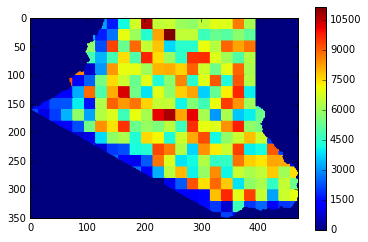

In [67]:
# the built-in python function map will sum the rasters
wildlife_demand = sum(total_forage_w)

visualize(wildlife_demand)

In [68]:
#wildlife_demand.store("wildlife_demand","GTiff","gdal")
wildlife_demand.store("wildlife_demand","map","ilwis3")

### 2.5 Livestock forage demand for the long dry season and sustainable available forage

For the livestock the forage demand is summed to obtain a map with the location and extent of the total livestock forage demand.

In [69]:
census_livestock = ilwis.RasterCoverage(ilwis.Engine.getLocation()+"/census_livestock.mpr")

total_forage_l = []

for code in livestock_dict:
    #print(code)
    density_l = ilwis.Engine.do("selection",census_livestock,'"attributes('+code+')"')
    demand_l = 6 * 30.4 * livestock_dict[code] * density_l
    
    total_forage_l.append(demand_l)


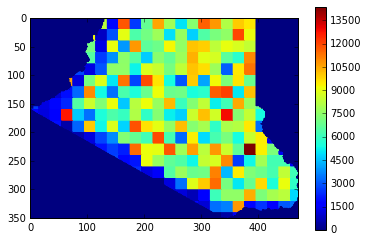

In [70]:
livestock_demand = sum(total_forage_l)

visualize(livestock_demand)

In [71]:
#livestock_demand.store("livestock_demand","GTiff","gdal")
livestock_demand.store("livestock_demand","map","ilwis3")

However there is a potential available amount of forage for livestock which is equal to the sustainable available forage minus the wildlife forage demand. <br/><br/>

<b>potential_available = sustainable_available - wildlife_demand</b>

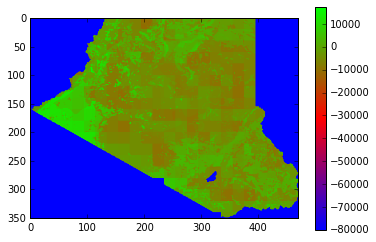

In [72]:
#import ilwisobjects as ilwis
#ilwis.disconnectIssueLogger()
#set your ilwisobjects current working catalog
#ilwis.Engine.setWorkingCatalog(r"C:\Python34\Scripts\geopython\data")

#sustainable_available = ilwis.RasterCoverage("sustainable_available.mpr")
#wildlife_demand = ilwis.RasterCoverage("wildlife_demand.mpr")

potential_available = sustainable_available - wildlife_demand

visualize(potential_available, minvalue = -80000, cmap= 'brg' )

In [73]:
#potential_available.store("potential_available","GTiff","gdal")
potential_available.store("potential_available","map","ilwis3")

## 3. ACCESSIBILITY

### 3.1 Suitability of the rangelands for livestock grazing

The suitability of the rangelands for grazing has to be applied. Factors like slope steepness will reduce the amount of forage to what is actually available for grazing

<i>Note: there are many other factors that might be considered such as surface roughness, hindrance by vegetation, extreme temperatures, flooding, predators, human berriers.</i>

<img src="files/images/suitability1.jpg" width=450>


In [74]:
# we classify the slope map according to the above table
# we can use a pixel iterator to check the update the pixel values

### note: due to a bug happening when the code run in ipython to rerun this code restart the kernel, 
### rerun the visualize function at point 1.1 , uncomment the 3 lines of code below

#import ilwisobjects as ilwis
#ilwis.disconnectIssueLogger()
#set your ilwisobjects current working catalog!
#ilwis.Engine.setWorkingCatalog(r"C:\Python34\Scripts\geopython\data")

slope = ilwis.RasterCoverage(ilwis.Engine.getLocation() + "/slope/slope_mamase.mpr")

size = slope.size().xsize * slope.size().ysize * slope.size().zsize

rciter = iter(slope)

for i in range(size):
    # print(float(rciter))
    if 0 <= float(rciter) < 15:
        rciter[i] = 100.0
        # print(float(rciter))
    elif 15 <= float(rciter) < 30:
        rciter[i] = 75.0
        # print(float(rciter))
    elif 30 <= float(rciter) <= 100:
        rciter[i] = 25.0
        # print(float(rciter))
    else:
        rciter[i] = 0.0
        # print(float(rciter))

    next(rciter) 


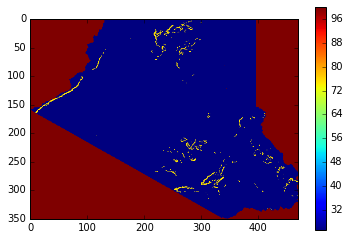

In [75]:
visualize(slope)

In [76]:
#slope.store("suitable","GTiff","gdal")
slope.store("suitable","map","ilwis3")

### 3.2 Potential forage available and suitable for livestock

The suitability map can be applied as a reduction factor for the potential available amount of forage for livestock

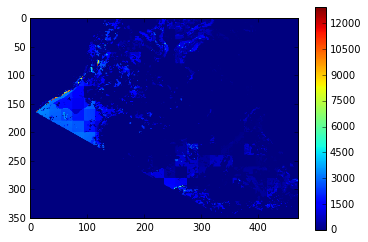

In [77]:
#potential_available= ilwis.RasterCoverage("potential_available.mpr")
#slope = ilwis.RasterCoverage("suitable.mpr")


potential_available_suitable = potential_available * (slope /100)

visualize(potential_available_suitable)

In [78]:
#potential_available_suitable.store("potential_available_suitable","GTiff","gdal")
potential_available_suitable.store("potential_available_suitable","map","ilwis3")

### 3.3 Accessibility aspect of the rangelands for livestock grazing

The availability of water is still a crucial point in the hearding strategy of the Maasai, together with the availability of forage. <br/>
The availability of water during the dry season depends on the existence of artificial water supply ( e.g. boreholes, pipeline water supply) and natural water supply (e.g. permanent rivers and swamps, springs, and wells. <br/>
The accessibility classification according to water drinking availability in the dry season will be
- 0-5 km: daily regime
- 5-12 km: every other day regime
- more than 12 km: inaccessible

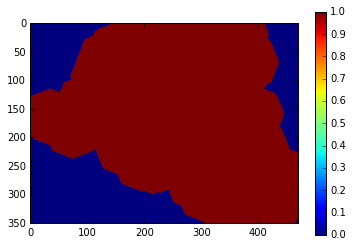

In [79]:
#calculating distanceraster and mask

#120716 temporary fix to ilwis not being able to load waterpoints.mpr with only the path to it
ilwis.Engine.setWorkingCatalog(ilwis.Engine.getLocation() + "/waterpoints")

rc = ilwis.RasterCoverage("Waterpoints.mpr")
rcdist = ilwis.Engine.do("distanceraster",rc)

#go back to current working catalog
ilwis.Engine.setWorkingCatalog(pth)

rcdist.store("pointdistance","GTiff", "gdal")
rc2 = ilwis.Engine.do("iff", rcdist > 12000, 0, 1)
rc2.store( "distance_mask"  ,"map", "ilwis3")

#####no_access = ilwis.RasterCoverage(ilwis.Engine.getLocation() + "/waterpoints/pointdistance/distance_mask.mpr")
no_access = ilwis.RasterCoverage("distance_mask.mpr")
visualize(no_access)

### 3.4 Extraction of livestock forage demand of the actual forage availability

The final rangeland management map can be obtained by subtracting  the livestock_demand from potential_available_suitable and multiplying the result by the no_access mask. <br/>

<b>rangeland_management = (potential_available_suitable - livestock_demand) * no_access</b><br/>

<u>The negative pixels indicate danger of overgrazing.</u>

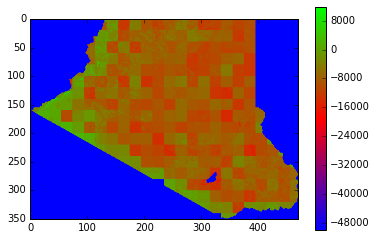

In [80]:
#potential_available_suitable2 = ilwis.RasterCoverage("potential_available_suitable.mpr")
#livestock_demand2 = ilwis.RasterCoverage("livestock_demand.mpr")
#no_access = ilwis.RasterCoverage(ilwis.Engine.getLocation() + "/waterpoints/pointdistance/distance_mask.mpr")

rangeland_management = (potential_available_suitable - livestock_demand) * no_access
visualize(rangeland_management, minvalue = -50000,  cmap='brg' )

## SOME LINKS

[MaMaSe project](http://www.mamase.org)

[Ilwisobjects tutorial](https://github.com/52North/IlwisCore/wiki/ILWIS-Python-API-Tutorial)

[Ilwisobjects downloads](https://github.com/52North/IlwisCore/releases/tag/v1.0-beta2.2)

[Ilwis software](http://52north.org/downloads/category/151-ilwis-3-08-05-package)

[Visualizing data with Ilwis](http://52north.org/files/ilwis/ILWIS_3.8_Map_Visualization.pdf)

[Ilwis 4 preview](https://vimeo.com/user29453510/review/153355429/1c1a97df84)